In [1]:
import pandas as pd 

data = pd.read_csv("../datasets/attribute_set/train_val_data_fine_grained_all.csv", index_col=0) 

In [2]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paths            16000 non-null  object
 1   floral           16000 non-null  int64 
 2   graphic          16000 non-null  int64 
 3   striped          16000 non-null  int64 
 4   embroidered      16000 non-null  int64 
 5   pleated          16000 non-null  int64 
 6   solid            16000 non-null  int64 
 7   lattice          16000 non-null  int64 
 8   long_sleeve      16000 non-null  int64 
 9   short_sleeve     16000 non-null  int64 
 10  sleeveless       16000 non-null  int64 
 11  maxi_length      16000 non-null  int64 
 12  mini_length      16000 non-null  int64 
 13  no_dress         16000 non-null  int64 
 14  crew_neckline    16000 non-null  int64 
 15  v_neckline       16000 non-null  int64 
 16  square_neckline  16000 non-null  int64 
 17  no_neckline      16000 non-null 

In [3]:
data.head() 

,paths,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,...,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,../datasets/big_ds/img-001/img/Sweet_Crochet_B...,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,../datasets/big_ds/img-001/img/Classic_Pencil_...,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,../datasets/big_ds/img-001/img/Strapless_Diamo...,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,../datasets/big_ds/img-001/img/Mid-Rise_-_Acid...,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,0
4,../datasets/big_ds/img-001/img/Zippered_Single...,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [4]:
TRAIN_SIZE = 14000

# Prepare Data Pipeline by using tf.data 

In [5]:
fnames = data.paths.to_numpy()  
fnames[:5], len(fnames)

(array(['../datasets/big_ds/img-001/img/Sweet_Crochet_Blouse/img_00000070.jpg',
        '../datasets/big_ds/img-001/img/Classic_Pencil_Skirt/img_00000010.jpg',
        '../datasets/big_ds/img-001/img/Strapless_Diamond_Print_Dress/img_00000038.jpg',
        '../datasets/big_ds/img-001/img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010.jpg',
        '../datasets/big_ds/img-001/img/Zippered_Single-Button_Blazer/img_00000078.jpg'],
       dtype=object),
 16000)

In [6]:
import tensorflow as tf 

ds_size = data.shape[0] 
number_of_selected_samples = 2000 

# filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples]) 
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames) 


filelist_ds.cardinality().numpy() 

16000

## Custom tf Helpers 

In [7]:
def get_label(file_path):
    """
        file_path: the file path for the image that you want to select
    """
    labels = data.loc[data.paths == file_path].to_numpy().squeeze()[1:].astype("int64")
    return tf.convert_to_tensor(labels) 

In [8]:
get_label(fnames[0])

<tf.Tensor: shape=(26,), dtype=int64, numpy=
array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1], dtype=int64)>

In [9]:
# resize and scale the images so that we can save time in training  
IMG_WIDTH, IMG_HEIGHT = 224, 224 
def decode_img(img):
    """
        img: img is the image 
    """ 
    #color images 
    img = tf.image.decode_jpeg(img, channels=3) 
    # img = tf.image.convert_image_dtype(img, tf.float32)  #convert unit8 tensor to floats in the [0,1] range
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
    # img = img / tf.constant(256, dtype=tf.float32)
    return img

In [10]:
def combine_images_labels(file_path: tf.Tensor): 
    label = get_label(file_path) 
    img = tf.io.read_file(file_path) 
    img = decode_img(img) 
    return img, label 

In [11]:
# combine_images_labels(fnames[0])

# Train/Test Split 

In [12]:
ds_train = filelist_ds.take(TRAIN_SIZE) 
ds_test = filelist_ds.skip(TRAIN_SIZE)

In [13]:
BATCH_SIZE = 32 

## Pre-process All the Images 

In [14]:
ds_train = ds_train.map(lambda x: 
                        tf.py_function(func=combine_images_labels, 
                                       inp=[x], # input of the function 
                                       Tout=(tf.float32,tf.int64)),  # return type 
                        num_parallel_calls=tf.data.AUTOTUNE, # parallelizing data extraction 
                        deterministic=False 
                        )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

### Prepare Data Pipeline 

- **batch**(): Combines consecutive elements of this dataset into batches.
- **cache**(): Caches the elements in this dataset. he first time the dataset is iterated over, its elements will be cached either in the specified file or in memory.Subsequent iterations will use the cached data.
- **prefetch**(): Creates a Dataset that prefetches elements from this dataset. Most dataset input pipelines should end with a call to *prefetch*. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
 

In [16]:
ds_train_batched = ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched = ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 

In [17]:
ds_train_batched.cardinality().numpy() 

438

In [18]:
nr_of_classes = len(data.columns) - 1  
nr_of_classes

26

# Model 1:Fine Grained VGG16 

In [106]:
from tensorflow import keras 
base_model = keras.applications.VGG16(
    weights="imagenet", # load weights pre-trained on ImageNet. 
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), # VGG16 expects min 32 x 32 
    include_top = False # do not include output layer of the image net vgg 
)
base_model.trainable = False 

In [107]:
inputs = keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.vgg16.preprocess_input(x)   
x = base_model(x) 
x = keras.layers.GlobalAveragePooling2D()(x) 

initializer = tf.keras.initializers.GlorotUniform(seed=42) 
activation = tf.keras.activations.sigmoid  

outputs = keras.layers.Dense(nr_of_classes,
                             kernel_initializer=initializer, 
                             activation=activation)(x) 

model_1 = keras.Model(inputs, outputs) 

In [108]:
model_1.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

In [109]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) 
checkpoint_path = "checkpoints/attribute_prediction_classifier_fine_grained/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

In [110]:
history_model_1 = model_1.fit(ds_train_batched, 
                            epochs=10,
                            validation_data =ds_test_batched,
                            callbacks=[early_stopping, checkpoint_callback]
                            )

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
# model_1.save("../trained_models/model_1_fine_grained_vgg.h5") 

# Model 2: Efficient Net 

In [ ]:
efficient_net = tf.keras.applications.EfficientNetB0(include_top=False)
efficient_net.trainable = False

In [ ]:
inputs = keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3)) 
x = efficient_net(inputs) 
x = keras.layers.GlobalAveragePooling2D()(x) 

initializer = tf.keras.initializers.GlorotUniform(seed=42) 
activation = tf.keras.activations.sigmoid  

outputs = keras.layers.Dense(nr_of_classes,
                             kernel_initializer=initializer, 
                             activation=activation)(x) 

model_2 = keras.Model(inputs, outputs) 

In [ ]:
model_2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
model_2.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 26)                33306     
                                                                 
Total params: 4,082,877
Trainable params: 33,306
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) 
checkpoint_path = "checkpoints/attribute_prediction_classifier_fine_grained_model3/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

In [ ]:
history_model_2 = model_2.fit(ds_train_batched, 
        validation_data =ds_test_batched,
        epochs=10,
        callbacks=[early_stopping, checkpoint_callback])

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 0.2891 - binary_accuracy: 0.8815
Epoch 1: val_loss improved from inf to 0.24964, saving model to checkpoints/attribute_prediction_classifier_fine_grained_model3\checkpoint.ckpt
438/438 [==============================] - 294s 650ms/step - loss: 0.2891 - binary_accuracy: 0.8815 - val_loss: 0.2496 - val_binary_accuracy: 0.8974
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.2440 - binary_accuracy: 0.8994
Epoch 2: val_loss improved from 0.24964 to 0.23676, saving model to checkpoints/attribute_prediction_classifier_fine_grained_model3\checkpoint.ckpt
438/438 [==============================] - 317s 721ms/step - loss: 0.2440 - binary_accuracy: 0.8994 - val_loss: 0.2368 - val_binary_accuracy: 0.9028
Epoch 3/10
438/438 [==============================] - ETA: 0s - loss: 0.2332 - binary_accuracy: 0.9036
Epoch 3: val_loss improved from 0.23676 to 0.23082, saving model to checkpoints/attribute_prediction_

In [ ]:
# model_2.save("../trained_models/model_2_fine_grained_vgg.h5") 

### Model 2 Fine Tune

In [ ]:
efficient_net.trainable = True  

for layer in efficient_net.layers[:-10]:
    layer.trainable = False 

model_2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
checkpoint_path = "checkpoints/attribute_prediction_classifier_fine_grained_model2_tune/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

In [ ]:
history_model_2_fine = model_2.fit(ds_train_batched, 
        validation_data =ds_test_batched,
        epochs=15, 
        initial_epoch=history_model_2.epoch[-1], # start from previous last epoch 
        callbacks=[checkpoint_callback])

Epoch 10/15
438/438 [==============================] - ETA: 0s - loss: 0.2235 - binary_accuracy: 0.9072
Epoch 10: saving model to checkpoints/attribute_prediction_classifier_fine_grained_model2_tune\checkpoint.ckpt
438/438 [==============================] - 465s 1s/step - loss: 0.2235 - binary_accuracy: 0.9072 - val_loss: 0.2200 - val_binary_accuracy: 0.9092
Epoch 11/15
438/438 [==============================] - ETA: 0s - loss: 0.1878 - binary_accuracy: 0.9226
Epoch 11: saving model to checkpoints/attribute_prediction_classifier_fine_grained_model2_tune\checkpoint.ckpt
438/438 [==============================] - 455s 1s/step - loss: 0.1878 - binary_accuracy: 0.9226 - val_loss: 0.2128 - val_binary_accuracy: 0.9135
Epoch 12/15
438/438 [==============================] - ETA: 0s - loss: 0.1663 - binary_accuracy: 0.9322
Epoch 12: saving model to checkpoints/attribute_prediction_classifier_fine_grained_model2_tune\checkpoint.ckpt
438/438 [==============================] - 471s 1s/step - loss:

In [ ]:
# model_2.save("../trained_models/fine_model_2_fine_grained_vgg.h5") 

# Model 3: EfficientNet with Data Augmentation 

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_model = Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2), 
    preprocessing.RandomZoom(0.2)
], name="data_augmentation") 

In [ ]:
from tensorflow import keras 

efficient_net_model_3 = tf.keras.applications.EfficientNetB0(include_top=False)
efficient_net_model_3.trainable = False 

inputs = keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3)) 
x = data_augmentation_model(inputs)
x = efficient_net_model_3(x, training=False) 
x = keras.layers.GlobalAveragePooling2D()(x) 

initializer = tf.keras.initializers.GlorotUniform(seed=42) 
activation = tf.keras.activations.sigmoid  

outputs = keras.layers.Dense(nr_of_classes,
                             kernel_initializer=initializer, 
                             activation=activation)(x) 

model_3 = keras.Model(inputs, outputs) 

In [ ]:
model_3.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
model_3.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 26)                33306     
                                                                 
Total params: 4,082,877
Trainable params: 33,306
Non-trainabl

In [ ]:
checkpoint_path = "checkpoints/model_3_fine_grained/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

In [ ]:
history_model_3 = model_3.fit(ds_train_batched, 
        validation_data =ds_test_batched,
        epochs=10, 
        callbacks=[checkpoint_callback])

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 0.2914 - binary_accuracy: 0.8799  
Epoch 1: saving model to checkpoints/model_3_fine_grained\checkpoint.ckpt
438/438 [==============================] - 65091s 149s/step - loss: 0.2914 - binary_accuracy: 0.8799 - val_loss: 0.2528 - val_binary_accuracy: 0.8951
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.2468 - binary_accuracy: 0.8978
Epoch 2: saving model to checkpoints/model_3_fine_grained\checkpoint.ckpt
438/438 [==============================] - 264s 596ms/step - loss: 0.2468 - binary_accuracy: 0.8978 - val_loss: 0.2395 - val_binary_accuracy: 0.9003
Epoch 3/10
438/438 [==============================] - ETA: 0s - loss: 0.2367 - binary_accuracy: 0.9016
Epoch 3: saving model to checkpoints/model_3_fine_grained\checkpoint.ckpt
438/438 [==============================] - 241s 552ms/step - loss: 0.2367 - binary_accuracy: 0.9016 - val_loss: 0.2337 - val_binary_accuracy: 0.9028
Epoch 4/10
438/438 

In [ ]:
# model_3.save("../trained_models/model_3_fine_grained.h5") 

# Evaluate Models 

### Evaluation of Model 1

In [22]:
model_1_loaded = tf.keras.models.load_model("../trained_models/model_1_fine_grained_vgg.h5")

In [23]:
model_1_loaded.layers

1/1 [==============================] - 0s 122ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              1.0
lattice            0.0
long_sleeve        0.0
short_sleeve       0.0
sleeveless         1.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      0.0
v_neckline         0.0
square_neckline    0.0
no_neckline        1.0
denim              0.0
chiffon            0.0
cotton             1.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


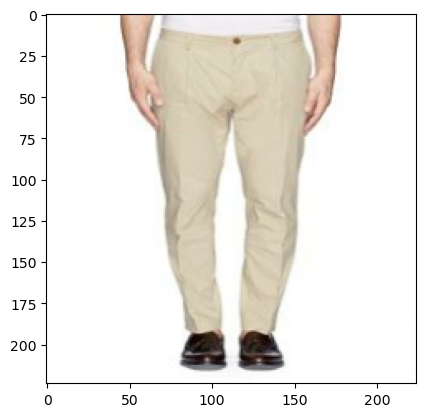

In [26]:
from helpers import show_image

print(evaluate_img(fnames[500], model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(fnames[500])